In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808333 sha256=ad61772ce7c0e2a72b9984255d5318cd077f7628c8b2db1a9005cba038dbce2e
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [3]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score, reciprocal_rank
from lightfm.cross_validation import random_train_test_split
import matplotlib.pyplot as plt
import joblib

In [4]:
# Load your data
users_df = pd.read_csv('/content/drive/MyDrive/recommendation_service_dataset/users.csv')
products_df = pd.read_csv('/content/drive/MyDrive/recommendation_service_dataset/products.csv')
events_df = pd.read_csv('/content/drive/MyDrive/recommendation_service_dataset/events.csv')


In [5]:
# Preprocessing
event_type_weights = {
    'purchase': 3.0,   # High weight as it directly indicates a preference.
    'cart': 2.5,       # Adding to cart is a strong buying signal.
    'product': 2.0,    # Viewing a product shows interest.
    'department': 1.0, # Browsing a department shows mild interest.
    'cancel': 0.5,     # Cancelling might indicate disinterest.
    'home': 0.5        # Visiting the home page is generic, low informational value.
}

events_df['event_weight'] = events_df['event_type'].map(event_type_weights)

events_df['product_id'] = events_df.apply(lambda row: int(row['uri'].split('/')[-1]) if '/product/' in row['uri'] else np.nan, axis=1)

events_df = events_df.dropna(subset=['product_id', 'user_id'])

events_df.loc[:, 'user_id'] = events_df['user_id'].astype(int)
events_df.loc[:, 'product_id'] = events_df['product_id'].astype(int)

filtered_events = events_df[events_df['user_id'].isin(users_df['id']) & events_df['product_id'].isin(products_df['id'])]

# Add age group feature to users
users_df['age_group'] = pd.cut(users_df['age'], bins=[0, 18, 25, 35, 45, 55, 65, 100], labels=['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+'])


print(filtered_events.head())
print(users_df.head())


    id  user_id  sequence_number                            session_id  \
2    3        1                3  2f64d862-461c-4aae-b6dc-01e0d196f798   
6    7        1                2  8a2213d3-4d80-4623-9310-5985e13cb40f   
9   10        1                5  8a2213d3-4d80-4623-9310-5985e13cb40f   
13  14        1                2  f3f101ae-94fa-4b90-af09-1ac93b882863   
16  17        1                5  f3f101ae-94fa-4b90-af09-1ac93b882863   

                 created_at      ip_address   city                state  \
2   2023-04-29 06:18:09 UTC   134.4.186.186  Wesel  Nordrhein-Westfalen   
6   2021-08-09 06:23:40 UTC  139.232.60.144  Wesel  Nordrhein-Westfalen   
9   2021-08-09 06:29:08 UTC  139.232.60.144  Wesel  Nordrhein-Westfalen   
13  2021-08-09 07:35:19 UTC    71.0.229.176  Wesel  Nordrhein-Westfalen   
16  2021-08-09 07:39:56 UTC    71.0.229.176  Wesel  Nordrhein-Westfalen   

   postal_code  browser traffic_source             uri event_type  \
2        46487   Chrome       Faceb

In [6]:
# Prepare the dataset
dataset = Dataset()
dataset.fit(
    users=(x for x in users_df['id']),
    items=(x for x in products_df['id']),
    user_features=(f"{row['gender']}_{row['age_group']}_{row['state']}" for index, row in users_df.iterrows()),
    item_features=(f"{row['category']}_{row['brand']}" for index, row in products_df.iterrows())
)

(interactions_matrix, weights_matrix) = dataset.build_interactions(
    (row['user_id'], row['product_id'], row['event_weight'])
    for index, row in events_df.iterrows()
)

user_features = dataset.build_user_features(
    (row['id'], [f"{row['gender']}_{row['age_group']}_{row['state']}"])
    for index, row in users_df[users_df['id'].isin(filtered_events['user_id'])].iterrows()
)

item_features = dataset.build_item_features(
    (row['id'], [f"{row['category']}_{row['brand']}"])
    for index, row in products_df[products_df['id'].isin(filtered_events['product_id'])].iterrows()
)



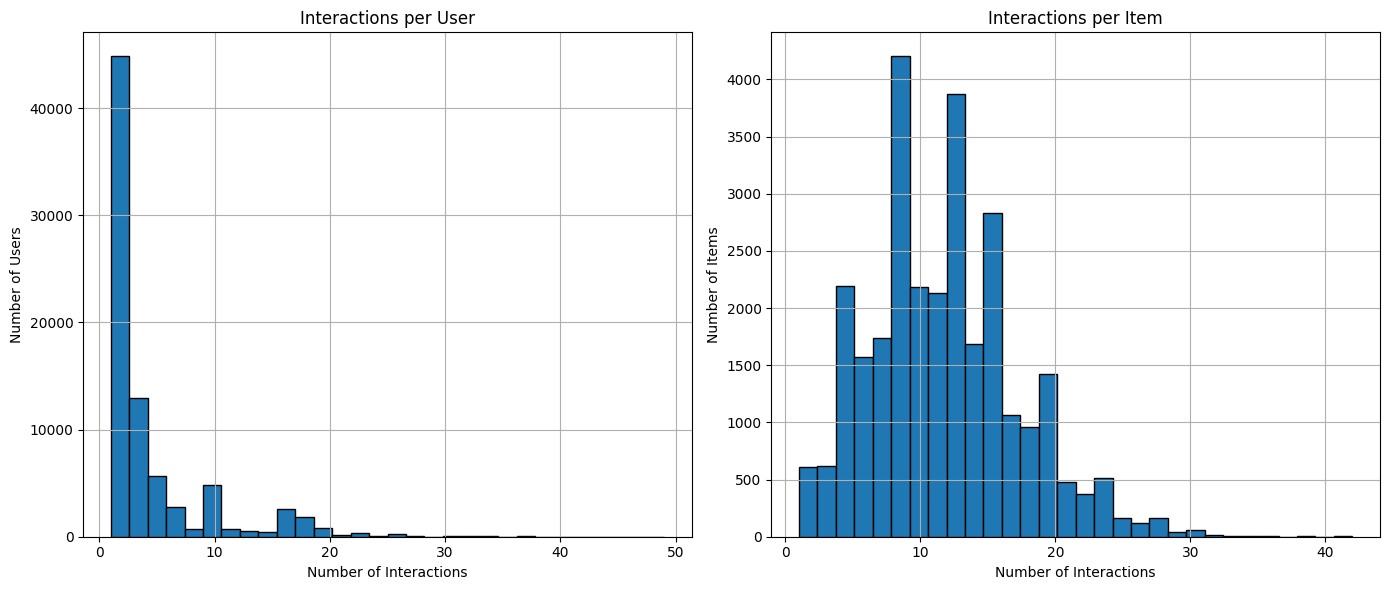

In [7]:
import matplotlib.pyplot as plt

# Assuming 'filtered_events' is your final events DataFrame after preprocessing
# Interactions per User
user_interactions = filtered_events.groupby('user_id').size()
item_interactions = filtered_events.groupby('product_id').size()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
user_interactions.hist(bins=30, edgecolor='black')
plt.title('Interactions per User')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')

plt.subplot(1, 2, 2)
item_interactions.hist(bins=30, edgecolor='black')
plt.title('Interactions per Item')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Items')

plt.tight_layout()
plt.show()


In [8]:
# Split the data into training and testing sets
train, test = random_train_test_split(interactions_matrix, test_percentage=0.2, random_state=np.random.RandomState(779))

# Initialize the LightFM model with WARP loss function
# Adjust these parameters to optimize the gap stability
learning_rate = 0.03  # Lower learning rate
no_components = 30    # Fewer factors to reduce complexity
user_alpha = 1e-4     # Higher regularization
item_alpha = 1e-4     # Higher regularization


# Initialize the model with adjusted parameters for better performance and regularization
model = LightFM(loss='warp', no_components=no_components,
                user_alpha=user_alpha, item_alpha=item_alpha,
                learning_schedule='adagrad', learning_rate=learning_rate, random_state=1616)

In [9]:
# Initialize lists to store the metrics
train_auc_list, test_auc_list, gap_list = [], [], []
train_rr_list, test_rr_list = [], []

num_epochs = 50
evaluation_interval = 5
best_gap = 0.05
patience = 3
patience_counter = 0
num_thread = 4

for epoch in range(num_epochs):
    model.fit_partial(train, user_features=user_features, item_features=item_features, epochs=1,
                      num_threads=num_thread)

    if (epoch + 1) % evaluation_interval == 0:
        train_rr = reciprocal_rank(model, train, user_features=user_features, item_features=item_features).mean()
        test_rr = reciprocal_rank(model, test, user_features=user_features, item_features=item_features).mean()
        train_auc = auc_score(model, train, user_features=user_features, item_features=item_features).mean()
        test_auc = auc_score(model, test, user_features=user_features, item_features=item_features).mean()

        current_gap = train_auc - test_auc
        train_rr_list.append(train_rr)
        test_rr_list.append(test_rr)
        train_auc_list.append(train_auc)
        test_auc_list.append(test_auc)
        gap_list.append(current_gap)

        print(f'Epoch: {epoch+1} - Train RR: {train_rr:.4f}, Test RR: {test_rr:.4f}')
        print(f'Epoch: {epoch+1} - Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}, Gap: {current_gap:.4f}')

        # Monitor the gap and apply early stopping if it exceeds the threshold
        if current_gap < best_gap:
            patience_counter = 0
            joblib.dump(model, '/content/best_recommendation_hybrid_model.pkl')  # Save the best model
        else:
            patience_counter += 1
            if patience_counter >= patience or current_gap > 0.05:
                print(f"Early stopping triggered due to gap exceeding {best_gap} or no improvement")
                break

Epoch: 5 - Train RR: 0.0030, Test RR: 0.0020
Epoch: 5 - Train AUC: 0.7902, Test AUC: 0.7758, Gap: 0.0144
Epoch: 10 - Train RR: 0.0038, Test RR: 0.0022
Epoch: 10 - Train AUC: 0.8066, Test AUC: 0.7858, Gap: 0.0208
Epoch: 15 - Train RR: 0.0049, Test RR: 0.0028
Epoch: 15 - Train AUC: 0.8184, Test AUC: 0.7923, Gap: 0.0260
Epoch: 20 - Train RR: 0.0063, Test RR: 0.0035
Epoch: 20 - Train AUC: 0.8289, Test AUC: 0.7981, Gap: 0.0308
Epoch: 25 - Train RR: 0.0084, Test RR: 0.0044
Epoch: 25 - Train AUC: 0.8391, Test AUC: 0.8035, Gap: 0.0356
Epoch: 30 - Train RR: 0.0103, Test RR: 0.0052
Epoch: 30 - Train AUC: 0.8494, Test AUC: 0.8087, Gap: 0.0407
Epoch: 35 - Train RR: 0.0129, Test RR: 0.0063
Epoch: 35 - Train AUC: 0.8597, Test AUC: 0.8140, Gap: 0.0457
Epoch: 40 - Train RR: 0.0158, Test RR: 0.0074
Epoch: 40 - Train AUC: 0.8700, Test AUC: 0.8193, Gap: 0.0507
Early stopping triggered due to gap exceeding 0.05 or no improvement


In [10]:
# Final evaluation at the end of training
train_precision = precision_at_k(model, train, k=10, user_features=user_features, item_features=item_features).mean()
test_precision = precision_at_k(model, test, k=10, user_features=user_features, item_features=item_features).mean()
train_auc = auc_score(model, train, user_features=user_features, item_features=item_features).mean()
test_auc = auc_score(model, test, user_features=user_features, item_features=item_features).mean()

print('Final evaluation results:')
print(f'Precision: Train {train_precision:.4f}, Test {test_precision:.4f}')
print(f'AUC: Train {train_auc:.4f}, Test {test_auc:.4f}')


Final evaluation results:
Precision: Train 0.0034, Test 0.0015
AUC: Train 0.8700, Test 0.8193


In [11]:
# Sample recommendation function
def sample_recommendation(model, user_id, user_features, item_features, dataset, num_items=10):
    n_users, n_items = dataset.interactions_shape()
    user_x = dataset.mapping()[0][user_id]
    scores = model.predict(user_x, np.arange(n_items), user_features=user_features, item_features=item_features)
    top_items = np.argsort(-scores)[:num_items]

    return [dataset.mapping()[2][i] for i in top_items]

# Test the recommendation function for a specific user 17033
user_id = 1
recommended_products = sample_recommendation(model, user_id, user_features, item_features, dataset)
print(f'Recommended product IDs for user {user_id}: {recommended_products}')

Recommended product IDs for user 1: [6852, 3394, 20814, 15078, 4998, 16958, 8947, 2213, 16829, 13525]


In [12]:
joblib.dump(model, 'recommendation_hybrid_model.pkl')

['recommendation_hybrid_model.pkl']

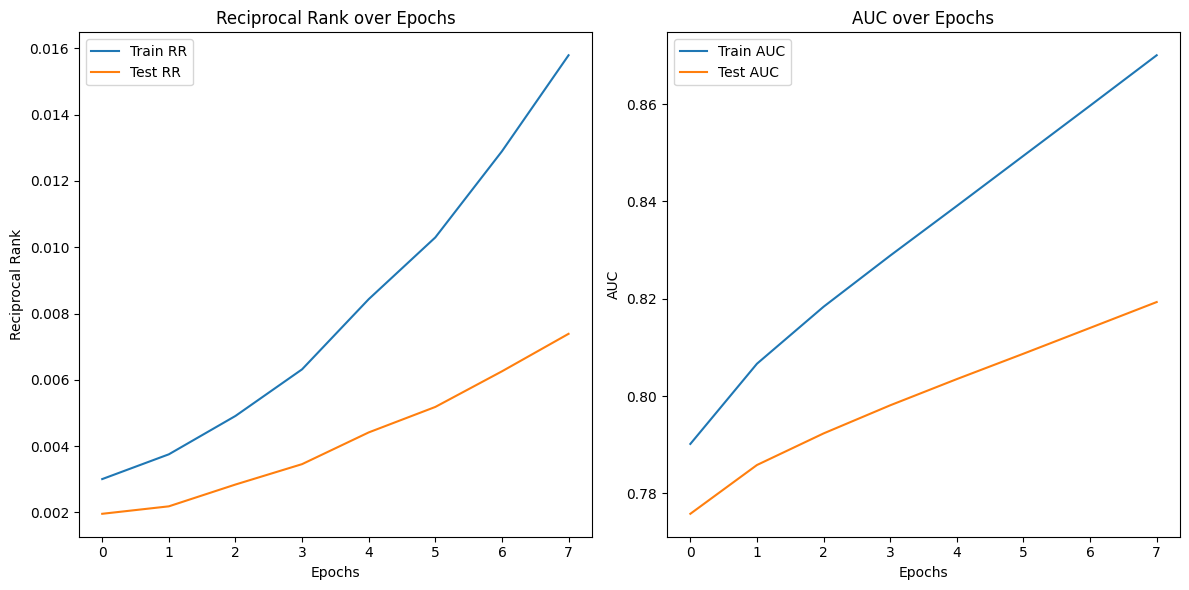

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(train_rr_list, label='Train RR')
plt.plot(test_rr_list, label='Test RR')
plt.title('Reciprocal Rank over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Reciprocal Rank')
plt.legend()

plt.subplot(122)
plt.plot(train_auc_list, label='Train AUC')
plt.plot(test_auc_list, label='Test AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()